## Кривоногов Н.В., PyTorch, практическое задание № 8

Обучить генератор создавать точки, которые будут лежать на графике функции 𝑦 = sin(𝑥) / 𝑥 − 𝑥 / 10.

При выполнении данного задания структура GAN остается той же, но Вам нужно:
- Сгенерировать настоящие данные
- Изменить архитектуру дискриминатора и генератора
- Построить графики

Загрузим необходимые библиотеки:

In [1]:
%matplotlib inline

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn

In [2]:
RANDOM_SEED = 42

Функция, данная по заданию:

In [3]:
def func(x):
    y = np.sin(x) / x - x / 10
    return y

Посмотрим, как выглядит её график:

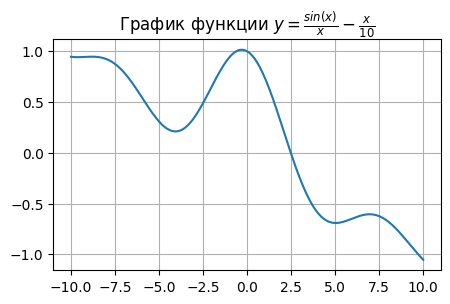

In [4]:
plt.figure(figsize=(5, 3))

x_orig = np.linspace(-10, 10, 200)
y_orig = func(x_orig)

plt.plot(x_orig, y_orig)
plt.title('График функции $y = \\frac{sin(x)}{x} - \\frac{x}{10}$')
plt.grid()
plt.show()

Инициализируем генератор и дискриминатор. Генератор будет принимать  
на вход шум размерностью *latent_dim* и генерировать пару координат точек.

In [5]:
class Generator(nn.Module):
    def __init__(self, latent_dim=4, hidden_dim=16):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 2)
        self.lrelu = nn.LeakyReLU(0.2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.lrelu(x)
        x = self.fc3(x)

        return x

Дискриминатор будет принимать пару координат *x, y* и возвращать  
вероятность того, что эта пара соответствует точке заданного графика.

In [6]:
class Discriminator(nn.Module):
    def __init__(self, hidden_dim=16):
        super().__init__()
        self.fc1 = nn.Linear(2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
        self.lrelu = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.fc1(x)
        x = self.lrelu(x)
        x = self.fc2(x)
        x = self.lrelu(x)
        x = self.fc3(x)
        x = torch.sigmoid(x)
        return x

Определим класс для генерирования датасета, состоящего из точек (x, y), лежащих на  
заданном графике:

In [7]:
class Numbers(torch.utils.data.Dataset):
    def __init__(self, length):
        self.length = length
        self.data = (torch.rand((length, 1)) * 2 - 1) * 10 # генерируем равномерное распределение от -10 до 10
        self.data = torch.stack((self.data, func(self.data)), dim=1)
        self.data = torch.squeeze(self.data)

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return self.length

Создадим датасет и обернём его в лоадер:

In [8]:
torch.random.manual_seed(RANDOM_SEED)

data = Numbers(50000)
BATCH_SIZE = 1024

loader = torch.utils.data.DataLoader(data,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True)

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

Обучим нейросети. В результате генератор должен научиться создавать точки  
в двумерном пространстве, лежащие на графике заданной функции, из случайных  
точек пространства *latent_dim*, взятых из стандартного нормального распределения.

[Epoch 1/300] [D loss: 0.5611891746520996] [G loss: 0.6797530651092529]


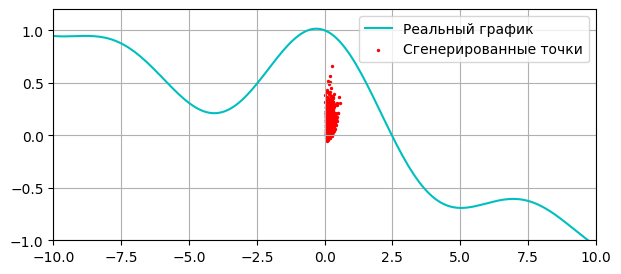

[Epoch 60/300] [D loss: 0.678936243057251] [G loss: 0.7180832028388977]


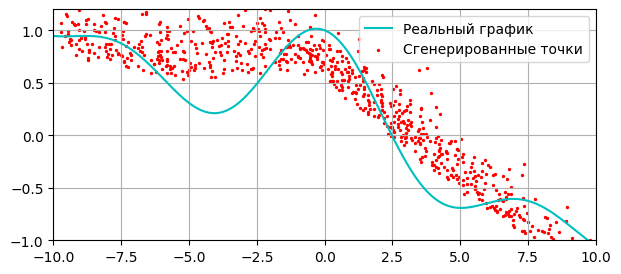

[Epoch 120/300] [D loss: 0.6877597570419312] [G loss: 0.7004319429397583]


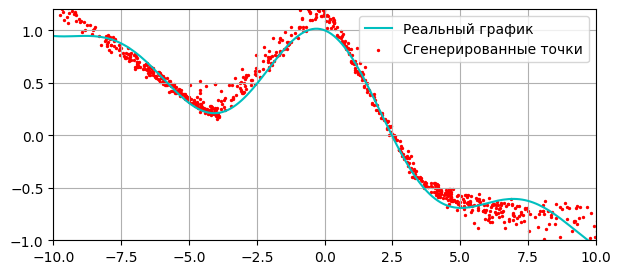

[Epoch 180/300] [D loss: 0.6869715452194214] [G loss: 0.7049669027328491]


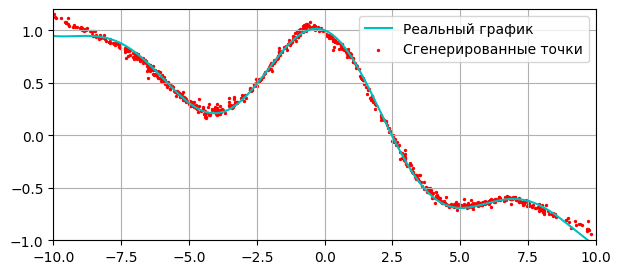

[Epoch 240/300] [D loss: 0.6918600797653198] [G loss: 0.6948078274726868]


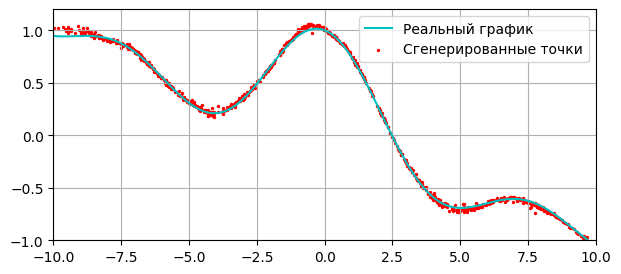

[Epoch 300/300] [D loss: 0.6912276744842529] [G loss: 0.6845008134841919]


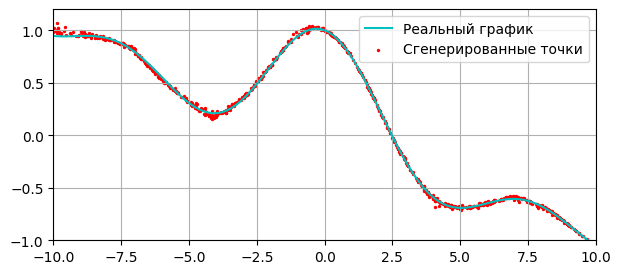

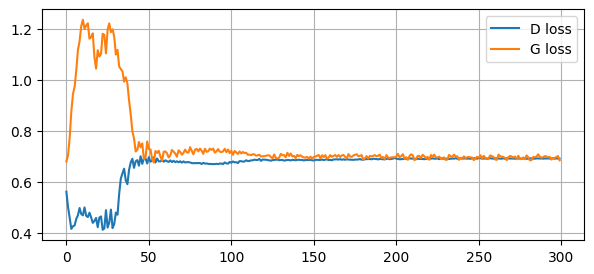

In [10]:
lr = 0.0001
epochs = 300
latent_dim = 4

torch.random.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True

generator = Generator(latent_dim=latent_dim, hidden_dim=64).to(device)
discriminator = Discriminator(64).to(device)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr)

adversarial_loss = torch.nn.BCELoss()

d_loss_history = []
g_loss_history = []

for epoch in range(epochs):
    for i, xy in enumerate(loader):

        # Создаём векторы таргетов реальных и сгенерированных данных для дискриминатора
        real = torch.FloatTensor(len(xy), 1).fill_(1.0).to(device)
        fake = torch.FloatTensor(len(xy), 1).fill_(0.0).to(device)

        xy = xy.to(device)

        # Генерируем вектор шума z
        z = torch.randn((len(xy), latent_dim)).to(device)

        # Создаём пары x, y генератором
        gen_numbers = generator(z)

######################  Тренировка дискриминатора    ##########################

        # Получаем предсказания дискриминатора на основе реальных данных
        real_pred = discriminator(xy)

        # Сравниваем предсказанные значения дискриминатора (на основе реальных данных) с настоящими.
        # Дискриминатор штрафуется, если не может распознать реальные данные.
        d_real_loss = adversarial_loss(real_pred, real)

        # Подаём сгенерированые данные на дискриминатор
        fake_pred = discriminator(gen_numbers)

        # Рассчитываем ошибку предсказанного с фейковыми лейблами.
        # Дискриминатор штрафуется, если принимает сгенерированные данные за реальные.
        d_fake_loss = adversarial_loss(fake_pred, fake)

        # Усредняем два лосса в один
        d_loss = (d_real_loss + d_fake_loss) / 2

        # Делаем шаг обучения дискриминатора
        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

######################  Тренировка генератора    ##########################

        # Генерируем вектор шума z
        z = torch.randn((len(xy), latent_dim)).to(device)

        # Создаём пары x, y генератором
        gen_numbers = generator(z)

        # Подаём сгенерированые данные на дискриминатор
        fake_pred = discriminator(gen_numbers)

        # Сравниваем предсказанные значения дискриминатора (на основе сгенерировнных данных) с настоящими.
        # Генератор штрафуется, если дискриминатор может отличить сгенерированные данные от реальных.
        g_loss = adversarial_loss(fake_pred, real)

        # Делаем шаг обучения генератора
        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

######## Отображение процесса обучения и вывод функций потерь ############

    d_loss_history.append(d_loss.item())
    g_loss_history.append(g_loss.item())

    # Каждые 60 эпох обучения будем выводить график
    # заданной функции и сгенерированные точки
    if epoch == 0 or (epoch+1) % 60 == 0:
        with torch.no_grad():
            # display.clear_output(wait=False)

            print(f"[Epoch {epoch+1}/{epochs}]", end=' ')
            print(f'[D loss: {d_loss.item()}] [G loss: {g_loss.item()}]')

            plt.figure(figsize=(7, 3))

            plt.plot(x_orig, y_orig, label='Реальный график', c='c')
            gen_numbers = gen_numbers.cpu().detach().numpy()
            plt.scatter(gen_numbers[:, 0], gen_numbers[:, 1], s=2, c='r', label='Сгенерированные точки')
            plt.xlim(-10, 10)
            plt.ylim(-1, 1.2)
            plt.grid()
            plt.legend()
            plt.show()

# Также в конце обучения посмотрим на график лоссов состязающихся нейросетей
plt.figure(figsize=(7, 3))
plt.plot(d_loss_history, label='D loss')
plt.plot(g_loss_history, label='G loss')
plt.grid()
plt.legend()
plt.show()

Научили генератор создавать из шума точки, лежащие на графике заданной функции.  
На графиках видим прогресс обучения, как модель постепенно находила паттерны:  
сначала основное направление графика, а потом все мелкие изгибы. После 300 эпох  
обучения генератор воспроизводит все изгибы графика с достаточно небольшой дисперсией.  
Лоссы обеих сетей практически сомкнулись в одну точку.